In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

# Load data from Google Drive
import pandas as pd
file_path = '/content/drive/MyDrive/AML Project/HI-Small_Trans.csv'
df = pd.read_csv(file_path)

# Check data
print(df.head())

Mounted at /content/drive
          Timestamp  From Bank    Account  To Bank  Account.1  \
0  2022/09/01 00:20         10  8000EBD30       10  8000EBD30   
1  2022/09/01 00:20       3208  8000F4580        1  8000F5340   
2  2022/09/01 00:00       3209  8000F4670     3209  8000F4670   
3  2022/09/01 00:02         12  8000F5030       12  8000F5030   
4  2022/09/01 00:06         10  8000F5200       10  8000F5200   

   Amount Received Receiving Currency  Amount Paid Payment Currency  \
0          3697.34          US Dollar      3697.34        US Dollar   
1             0.01          US Dollar         0.01        US Dollar   
2         14675.57          US Dollar     14675.57        US Dollar   
3          2806.97          US Dollar      2806.97        US Dollar   
4         36682.97          US Dollar     36682.97        US Dollar   

  Payment Format  Is Laundering  
0   Reinvestment              0  
1         Cheque              0  
2   Reinvestment              0  
3   Reinvestment    

In [ ]:
# Dataset Dimensions
print("Dataset Size:", df.shape)

# Column Information
print("Column Information:")
print(df.info())

Dataset Size: (5078345, 11)
Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078345 entries, 0 to 5078344
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Timestamp           object 
 1   From Bank           int64  
 2   Account             object 
 3   To Bank             int64  
 4   Account.1           object 
 5   Amount Received     float64
 6   Receiving Currency  object 
 7   Amount Paid         float64
 8   Payment Currency    object 
 9   Payment Format      object 
 10  Is Laundering       int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 426.2+ MB
None


In [ ]:
# Missing Values
print("Missing Values:")
print(df.isnull().sum())

# Duplicate Values
print("Duplicate Rows:", df.duplicated().sum())

Missing Values:
Timestamp             0
From Bank             0
Account               0
To Bank               0
Account.1             0
Amount Received       0
Receiving Currency    0
Amount Paid           0
Payment Currency      0
Payment Format        0
Is Laundering         0
dtype: int64
Duplicate Rows: 9


In [ ]:
# Remove duplicate rows
df = df.drop_duplicates()

# Verify removal of duplicates
print("Remaining Duplicates:", df.duplicated().sum())

Remaining Duplicates: 0


Is Laundering
0    5073159
1       5177
Name: count, dtype: int64


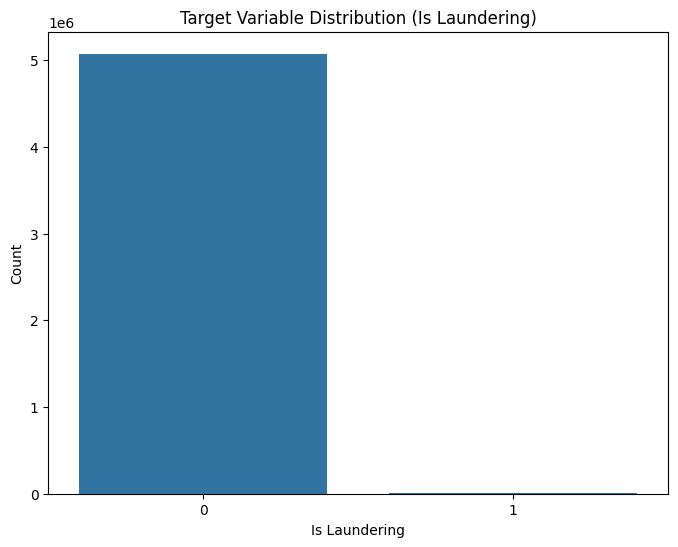

In [ ]:
# Analyze target variable distribution
print(df['Is Laundering'].value_counts())

# Visualize the distribution
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.countplot(x='Is Laundering', data=df)
plt.title('Target Variable Distribution (Is Laundering)')
plt.xlabel('Is Laundering')
plt.ylabel('Count')
plt.show()

In [ ]:
# Convert Timestamp to datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Extract time-based features
df['Hour'] = df['Timestamp'].dt.hour
df['Day'] = df['Timestamp'].dt.day
df['Month'] = df['Timestamp'].dt.month
df['Year'] = df['Timestamp'].dt.year
df['Weekday'] = df['Timestamp'].dt.weekday  # 0: Monday, 6: Sunday

# Normalize Timestamp
df['Timestamp_Normalized'] = (df['Timestamp'] - df['Timestamp'].min()) / (df['Timestamp'].max() - df['Timestamp'].min())

# Drop original timestamp if no longer needed
df.drop('Timestamp', axis=1, inplace=True)

# Display updated data
print(df.head())

   From Bank    Account  To Bank  Account.1  Amount Received  \
0         10  8000EBD30       10  8000EBD30          3697.34   
1       3208  8000F4580        1  8000F5340             0.01   
2       3209  8000F4670     3209  8000F4670         14675.57   
3         12  8000F5030       12  8000F5030          2806.97   
4         10  8000F5200       10  8000F5200         36682.97   

  Receiving Currency  Amount Paid Payment Currency Payment Format  \
0          US Dollar      3697.34        US Dollar   Reinvestment   
1          US Dollar         0.01        US Dollar         Cheque   
2          US Dollar     14675.57        US Dollar   Reinvestment   
3          US Dollar      2806.97        US Dollar   Reinvestment   
4          US Dollar     36682.97        US Dollar   Reinvestment   

   Is Laundering  Hour  Day  Month  Year  Weekday  Timestamp_Normalized  
0              0     0    1      9  2022        3              0.000786  
1              0     0    1      9  2022        3   

In [ ]:
# Create unique account IDs
df['From_Account'] = df['From Bank'].astype(str) + '_' + df['Account']
df['To_Account'] = df['To Bank'].astype(str) + '_' + df['Account.1']

# Transaction differences
df['Transaction Difference'] = df['Amount Paid'] - df['Amount Received']

# Transaction frequency per account
transaction_count = df.groupby('From_Account')['From_Account'].transform('count')
df['Transaction Count'] = transaction_count

# Total transaction amounts sent and received
df['Total Amount Sent'] = df.groupby('From_Account')['Amount Paid'].transform('sum')
df['Total Amount Received'] = df.groupby('To_Account')['Amount Received'].transform('sum')

# Anomaly detection based on transaction difference
df['Is_Anomaly'] = 0  # Default 0
df.loc[(df['Transaction Difference'] > 1000) | (df['Transaction Difference'] < -1000), 'Is_Anomaly'] = 1

# Display updated dataset
print(df.head())

   From Bank    Account  To Bank  Account.1  Amount Received  \
0         10  8000EBD30       10  8000EBD30          3697.34   
1       3208  8000F4580        1  8000F5340             0.01   
2       3209  8000F4670     3209  8000F4670         14675.57   
3         12  8000F5030       12  8000F5030          2806.97   
4         10  8000F5200       10  8000F5200         36682.97   

  Receiving Currency  Amount Paid Payment Currency Payment Format  \
0          US Dollar      3697.34        US Dollar   Reinvestment   
1          US Dollar         0.01        US Dollar         Cheque   
2          US Dollar     14675.57        US Dollar   Reinvestment   
3          US Dollar      2806.97        US Dollar   Reinvestment   
4          US Dollar     36682.97        US Dollar   Reinvestment   

   Is Laundering  ...  Year  Weekday  Timestamp_Normalized    From_Account  \
0              0  ...  2022        3              0.000786    10_8000EBD30   
1              0  ...  2022        3        

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode currency columns
encoder = LabelEncoder()
df['Receiving Currency'] = encoder.fit_transform(df['Receiving Currency'])
df['Payment Currency'] = encoder.fit_transform(df['Payment Currency'])

# Currency Conversion Analysis
df['Currency Difference'] = df['Payment Currency'] - df['Receiving Currency']

# Check unique currencies
print("Unique Currencies in Receiving:", df['Receiving Currency'].unique())
print("Unique Currencies in Payment:", df['Payment Currency'].unique())

# Display updated dataset
print(df[['Receiving Currency', 'Payment Currency', 'Currency Difference']].head())

Unique Currencies in Receiving: [12  1  4  0 14  7  5 13 11  6  3 10  2  8  9]
Unique Currencies in Payment: [12  1  4  0 14  7 13  5 11  6  3 10  2  8  9]
   Receiving Currency  Payment Currency  Currency Difference
0                  12                12                    0
1                  12                12                    0
2                  12                12                    0
3                  12                12                    0
4                  12                12                    0


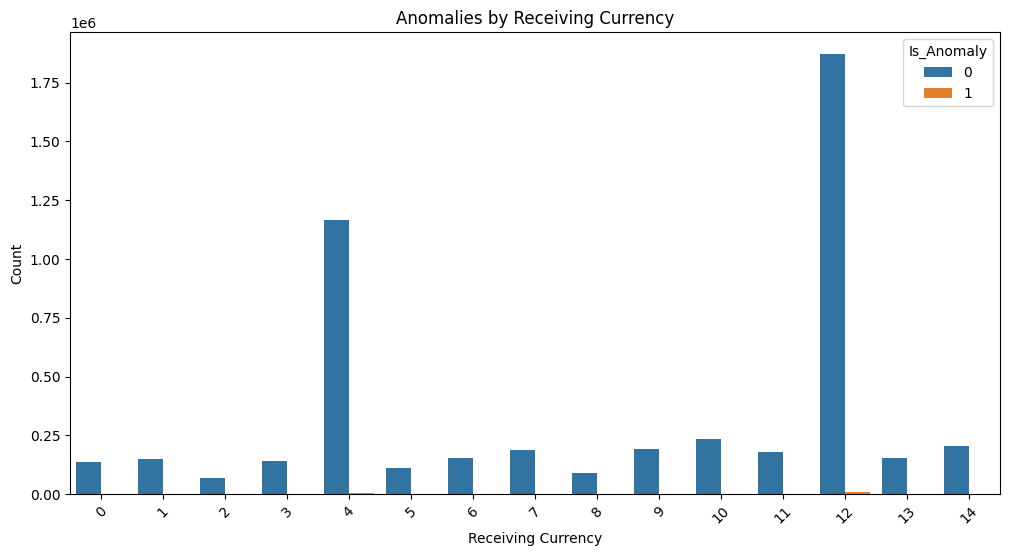

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Anomalilerin para birimleri ile analizi
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Receiving Currency', hue='Is_Anomaly')
plt.title('Anomalies by Receiving Currency')
plt.xlabel('Receiving Currency')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Check label encoding mapping
currency_mapping = dict(enumerate(encoder.classes_))
print(currency_mapping)

{0: 'Australian Dollar', 1: 'Bitcoin', 2: 'Brazil Real', 3: 'Canadian Dollar', 4: 'Euro', 5: 'Mexican Peso', 6: 'Ruble', 7: 'Rupee', 8: 'Saudi Riyal', 9: 'Shekel', 10: 'Swiss Franc', 11: 'UK Pound', 12: 'US Dollar', 13: 'Yen', 14: 'Yuan'}


In [ ]:
# Exchange rates
exchange_rates = {
    'Australian Dollar': 0.65,
    'Bitcoin': 90000.0,  # 1 BTC = 90,000 USD
    'Brazil Real': 0.20,
    'Canadian Dollar': 0.75,
    'Euro': 1.10,
    'Mexican Peso': 0.05,
    'Ruble': 0.014,
    'Rupee': 0.012,
    'Saudi Riyal': 0.27,
    'Shekel': 0.28,
    'Swiss Franc': 1.05,
    'UK Pound': 1.25,
    'US Dollar': 1.0,
    'Yen': 0.007,
    'Yuan': 0.14
}

# Map exchange rates to rows
df['Receiving Rate'] = df['Receiving Currency'].map(currency_mapping).map(exchange_rates)
df['Payment Rate'] = df['Payment Currency'].map(currency_mapping).map(exchange_rates)

# Convert amounts to USD
df['Amount Received USD'] = df['Amount Received'] * df['Receiving Rate']
df['Amount Paid USD'] = df['Amount Paid'] * df['Payment Rate']

# Display updated dataset
print(df[['Amount Received', 'Receiving Currency', 'Amount Received USD',
          'Amount Paid', 'Payment Currency', 'Amount Paid USD']].head())

   Amount Received  Receiving Currency  Amount Received USD  Amount Paid  \
0          3697.34                  12              3697.34      3697.34   
1             0.01                  12                 0.01         0.01   
2         14675.57                  12             14675.57     14675.57   
3          2806.97                  12              2806.97      2806.97   
4         36682.97                  12             36682.97     36682.97   

   Payment Currency  Amount Paid USD  
0                12          3697.34  
1                12             0.01  
2                12         14675.57  
3                12          2806.97  
4                12         36682.97  


In [ ]:
# Check if payment and receiving currencies differ
df['Currency Mismatch'] = (df['Receiving Currency'] != df['Payment Currency']).astype(int)

# Display updated data
print(df[['Receiving Currency', 'Payment Currency', 'Currency Mismatch']].head())

   Receiving Currency  Payment Currency  Currency Mismatch
0                  12                12                  0
1                  12                12                  0
2                  12                12                  0
3                  12                12                  0
4                  12                12                  0


In [ ]:
# Count the number of mismatched currencies
currency_mismatch_count = df['Currency Mismatch'].value_counts()

# Display results
print("Currency Mismatch Counts:")
print(currency_mismatch_count)

# Check rows with mismatched currencies
mismatch_rows = df[df['Currency Mismatch'] == 1]
print("\nExamples of Mismatched Currencies:")
print(mismatch_rows[['Receiving Currency', 'Payment Currency', 'Currency Mismatch']].head(10))

Currency Mismatch Counts:
Currency Mismatch
0    5006170
1      72166
Name: count, dtype: int64

Examples of Mismatched Currencies:
       Receiving Currency  Payment Currency  Currency Mismatch
1173                    4                12                  1
7156                    4                12                  1
7925                    0                12                  1
8467                    4                12                  1
11529                   4                12                  1
12678                   4                12                  1
12833                   4                12                  1
13332                   4                12                  1
18259                  12                 4                  1
18261                  12                 4                  1


In [ ]:
# Display updated dataset
print(df.head())

   From Bank    Account  To Bank  Account.1  Amount Received  \
0         10  8000EBD30       10  8000EBD30          3697.34   
1       3208  8000F4580        1  8000F5340             0.01   
2       3209  8000F4670     3209  8000F4670         14675.57   
3         12  8000F5030       12  8000F5030          2806.97   
4         10  8000F5200       10  8000F5200         36682.97   

   Receiving Currency  Amount Paid  Payment Currency Payment Format  \
0                  12      3697.34                12   Reinvestment   
1                  12         0.01                12         Cheque   
2                  12     14675.57                12   Reinvestment   
3                  12      2806.97                12   Reinvestment   
4                  12     36682.97                12   Reinvestment   

   Is Laundering  ...  Transaction Count  Total Amount Sent  \
0              0  ...                  2            3844.00   
1              0  ...                  3            1440.67   

In [ ]:
# Create unique account IDs
df['From_Account'] = df['From Bank'].astype(str) + '_' + df['Account']
df['To_Account'] = df['To Bank'].astype(str) + '_' + df['Account.1']

# Check the results
print(df[['From_Account', 'To_Account']].head())

     From_Account      To_Account
0    10_8000EBD30    10_8000EBD30
1  3208_8000F4580     1_8000F5340
2  3209_8000F4670  3209_8000F4670
3    12_8000F5030    12_8000F5030
4    10_8000F5200    10_8000F5200


In [ ]:
# Drop the 'Currency Difference' column
df.drop('Currency Difference', axis=1, inplace=True)

# Check the updated columns
print(df.columns)

In [ ]:
# Display updated dataset
print(df.head())

   From Bank    Account  To Bank  Account.1  Amount Received  \
0         10  8000EBD30       10  8000EBD30          3697.34   
1       3208  8000F4580        1  8000F5340             0.01   
2       3209  8000F4670     3209  8000F4670         14675.57   
3         12  8000F5030       12  8000F5030          2806.97   
4         10  8000F5200       10  8000F5200         36682.97   

   Receiving Currency  Amount Paid  Payment Currency Payment Format  \
0                  12      3697.34                12   Reinvestment   
1                  12         0.01                12         Cheque   
2                  12     14675.57                12   Reinvestment   
3                  12      2806.97                12   Reinvestment   
4                  12     36682.97                12   Reinvestment   

   Is Laundering  ...  Transaction Difference  Transaction Count  \
0              0  ...                     0.0                  2   
1              0  ...                     0.0       

In [ ]:
# Check the updated columns
print(df.columns)

Index(['From Bank', 'Account', 'To Bank', 'Account.1', 'Amount Received',
       'Receiving Currency', 'Amount Paid', 'Payment Currency',
       'Payment Format', 'Is Laundering', 'Hour', 'Day', 'Month', 'Year',
       'Weekday', 'Timestamp_Normalized', 'From_Account', 'To_Account',
       'Transaction Difference', 'Transaction Count', 'Total Amount Sent',
       'Total Amount Received', 'Is_Anomaly', 'Receiving Rate', 'Payment Rate',
       'Amount Received USD', 'Amount Paid USD', 'Currency Mismatch'],
      dtype='object')


In [ ]:
df.drop(['Account', 'Account.1'], axis=1, inplace=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['Payment Format'] = encoder.fit_transform(df['Payment Format'])

In [ ]:
df['Recent Activity'] = df.groupby('From_Account')['Timestamp_Normalized'].diff().fillna(0)

In [ ]:
df['Self_Loop'] = (df['From_Account'] == df['To_Account']).astype(int)

In [ ]:
df['Is_Laundering'] = df['Is Laundering'].astype('int8')
df['Is_Anomaly'] = df['Is_Anomaly'].astype('int8')
df['Currency Mismatch'] = df['Currency Mismatch'].astype('int8')

In [ ]:
df.drop(['Receiving Rate', 'Payment Rate'], axis=1, inplace=True)

In [ ]:
# Check the updated columns
print(df.columns)

Index(['From Bank', 'To Bank', 'Amount Received', 'Receiving Currency',
       'Amount Paid', 'Payment Currency', 'Payment Format', 'Is Laundering',
       'Hour', 'Day', 'Month', 'Year', 'Weekday', 'Timestamp_Normalized',
       'From_Account', 'To_Account', 'Transaction Difference',
       'Transaction Count', 'Total Amount Sent', 'Total Amount Received',
       'Is_Anomaly', 'Amount Received USD', 'Amount Paid USD',
       'Currency Mismatch', 'Recent Activity', 'Self_Loop', 'Is_Laundering'],
      dtype='object')


In [ ]:
# Display updated dataset
print(df.head())

   From Bank  To Bank  Amount Received  Receiving Currency  Amount Paid  \
0         10       10          3697.34                  12      3697.34   
1       3208        1             0.01                  12         0.01   
2       3209     3209         14675.57                  12     14675.57   
3         12       12          2806.97                  12      2806.97   
4         10       10         36682.97                  12     36682.97   

   Payment Currency  Payment Format  Is Laundering  Hour  Day  ...  \
0                12               5              0     0    1  ...   
1                12               3              0     0    1  ...   
2                12               5              0     0    1  ...   
3                12               5              0     0    1  ...   
4                12               5              0     0    1  ...   

   Transaction Count  Total Amount Sent  Total Amount Received  Is_Anomaly  \
0                  2            3844.00           

In [ ]:
# Configure plotly and pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.expand_frame_repr', False)

In [ ]:
# Display updated dataset
print(df.head())

   From Bank  To Bank  Amount Received  Receiving Currency  Amount Paid  Payment Currency  Payment Format  Is Laundering  Hour  Day  Month  Year  Weekday  Timestamp_Normalized    From_Account      To_Account  Transaction Difference  Transaction Count  Total Amount Sent  Total Amount Received  Is_Anomaly  Amount Received USD  Amount Paid USD  Currency Mismatch  Recent Activity  Self_Loop  Is_Laundering
0         10       10          3697.34                  12      3697.34                12               5              0     0    1      9  2022        3              0.000786    10_8000EBD30    10_8000EBD30                     0.0                  2            3844.00                4622.33           0              3697.34          3697.34                  0              0.0          1              0
1       3208        1             0.01                  12         0.01                12               3              0     0    1      9  2022        3              0.000786  3208_8000F458

In [ ]:
# Check if transactions are between different banks
df['Inter_Bank'] = (df['From Bank'] != df['To Bank']).astype(int)

# Verify the new column
print(df[['From Bank', 'To Bank', 'Inter_Bank']].head(10))

   From Bank  To Bank  Inter_Bank
0         10       10           0
1       3208        1           1
2       3209     3209           0
3         12       12           0
4         10       10           0
5          1        1           0
6          1        1           0
7          1        1           0
8         12     2439           1
9          1   211050           1


In [ ]:
# Print payment format mappings
payment_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print("Payment Format Mapping:", payment_mapping)

Payment Format Mapping: {'ACH': 0, 'Bitcoin': 1, 'Cash': 2, 'Cheque': 3, 'Credit Card': 4, 'Reinvestment': 5, 'Wire': 6}


In [ ]:
# Recalculate total amounts based on USD values
df['Total Amount Sent USD'] = df.groupby('From_Account')['Amount Paid USD'].transform('sum')
df['Total Amount Received USD'] = df.groupby('To_Account')['Amount Received USD'].transform('sum')

# Drop old columns
df.drop(['Total Amount Sent', 'Total Amount Received'], axis=1, inplace=True)

# Display updated dataset
print(df[['From_Account', 'To_Account', 'Total Amount Sent USD', 'Total Amount Received USD']].head(10))

     From_Account        To_Account  Total Amount Sent USD  Total Amount Received USD
0    10_8000EBD30      10_8000EBD30           3.844000e+03               4.622330e+03
1  3208_8000F4580       1_8000F5340           1.440670e+03               1.799880e+03
2  3209_8000F4670    3209_8000F4670           1.467557e+04               1.467557e+04
3    12_8000F5030      12_8000F5030           2.353331e+05               1.391968e+05
4    10_8000F5200      10_8000F5200           1.539132e+06               3.744688e+04
5     1_8000F5AD0       1_8000F5AD0           7.819020e+03               8.678400e+03
6     1_8000EBAC0       1_8000EBAC0           1.787491e+07               1.720088e+07
7     1_8000EC1E0       1_8000EC1E0           3.110195e+05               1.224170e+03
8    12_8000EC280    2439_8017BF800           2.073557e+04               7.944953e+04
9     1_8000EDEC0  211050_80AEF5310           3.593183e+06               1.698079e+05


In [ ]:

# Recalculate total amounts based on USD values
df['Total Amount Sent USD'] = df.groupby('From_Account')['Amount Paid USD'].transform('sum')
df['Total Amount Received USD'] = df.groupby('To_Account')['Amount Received USD'].transform('sum')

# Remove faulty or outdated columns (for security)
columns_to_drop = ['Total Amount Sent', 'Total Amount Received',]
df.drop(columns=[col for col in columns_to_drop if col in df.columns], axis=1, inplace=True)

# Update columns
print(df[['From_Account', 'To_Account', 'Total Amount Sent USD', 'Total Amount Received USD']].head(10))

     From_Account        To_Account  Total Amount Sent USD  Total Amount Received USD
0    10_8000EBD30      10_8000EBD30           3.844000e+03               4.622330e+03
1  3208_8000F4580       1_8000F5340           1.440670e+03               1.799880e+03
2  3209_8000F4670    3209_8000F4670           1.467557e+04               1.467557e+04
3    12_8000F5030      12_8000F5030           2.353331e+05               1.391968e+05
4    10_8000F5200      10_8000F5200           1.539132e+06               3.744688e+04
5     1_8000F5AD0       1_8000F5AD0           7.819020e+03               8.678400e+03
6     1_8000EBAC0       1_8000EBAC0           1.787491e+07               1.720088e+07
7     1_8000EC1E0       1_8000EC1E0           3.110195e+05               1.224170e+03
8    12_8000EC280    2439_8017BF800           2.073557e+04               7.944953e+04
9     1_8000EDEC0  211050_80AEF5310           3.593183e+06               1.698079e+05


In [ ]:
columns_to_drop = [
    'Total Amount Sent',
    'Total Amount Received',
    'Total Amount Sent USD',
    'Total Amount Received USD'
]

# drop
df.drop(columns=[col for col in columns_to_drop if col in df.columns], axis=1, inplace=True)

# control
print(df.columns)

Index(['From Bank', 'To Bank', 'Amount Received', 'Receiving Currency',
       'Amount Paid', 'Payment Currency', 'Payment Format', 'Is Laundering',
       'Hour', 'Day', 'Month', 'Year', 'Weekday', 'Timestamp_Normalized',
       'From_Account', 'To_Account', 'Transaction Difference',
       'Transaction Count', 'Is_Anomaly', 'Amount Received USD',
       'Amount Paid USD', 'Currency Mismatch', 'Recent Activity', 'Self_Loop',
       'Is_Laundering', 'Inter_Bank'],
      dtype='object')


In [ ]:
# recalculate
df['Total Amount Sent USD'] = df.groupby('From_Account')['Amount Paid USD'].transform('sum')
df['Total Amount Received USD'] = df.groupby('To_Account')['Amount Received USD'].transform('sum')

# display
print(df[['From_Account', 'To_Account', 'Total Amount Sent USD', 'Total Amount Received USD']].head(10))

     From_Account        To_Account  Total Amount Sent USD  Total Amount Received USD
0    10_8000EBD30      10_8000EBD30           3.844000e+03               4.622330e+03
1  3208_8000F4580       1_8000F5340           1.440670e+03               1.799880e+03
2  3209_8000F4670    3209_8000F4670           1.467557e+04               1.467557e+04
3    12_8000F5030      12_8000F5030           2.353331e+05               1.391968e+05
4    10_8000F5200      10_8000F5200           1.539132e+06               3.744688e+04
5     1_8000F5AD0       1_8000F5AD0           7.819020e+03               8.678400e+03
6     1_8000EBAC0       1_8000EBAC0           1.787491e+07               1.720088e+07
7     1_8000EC1E0       1_8000EC1E0           3.110195e+05               1.224170e+03
8    12_8000EC280    2439_8017BF800           2.073557e+04               7.944953e+04
9     1_8000EDEC0  211050_80AEF5310           3.593183e+06               1.698079e+05


In [ ]:
print(df.columns)

Index(['From Bank', 'To Bank', 'Amount Received', 'Receiving Currency',
       'Amount Paid', 'Payment Currency', 'Payment Format', 'Is Laundering',
       'Hour', 'Day', 'Month', 'Year', 'Weekday', 'Timestamp_Normalized',
       'From_Account', 'To_Account', 'Transaction Difference',
       'Transaction Count', 'Is_Anomaly', 'Amount Received USD',
       'Amount Paid USD', 'Currency Mismatch', 'Recent Activity', 'Self_Loop',
       'Is_Laundering', 'Inter_Bank', 'Total Amount Sent USD',
       'Total Amount Received USD'],
      dtype='object')


In [ ]:
# Display updated dataset
print(df.head())

   From Bank  To Bank  Amount Received  Receiving Currency  Amount Paid  Payment Currency  Payment Format  Is Laundering  Hour  Day  Month  Year  Weekday  Timestamp_Normalized    From_Account      To_Account  Transaction Difference  Transaction Count  Is_Anomaly  Amount Received USD  Amount Paid USD  Currency Mismatch  Recent Activity  Self_Loop  Is_Laundering  Inter_Bank  Total Amount Sent USD  Total Amount Received USD
0         10       10          3697.34                  12      3697.34                12               5              0     0    1      9  2022        3              0.000786    10_8000EBD30    10_8000EBD30                     0.0                  2           0              3697.34          3697.34                  0              0.0          1              0           0               3844.000                   4622.330
1       3208        1             0.01                  12         0.01                12               3              0     0    1      9  2022      

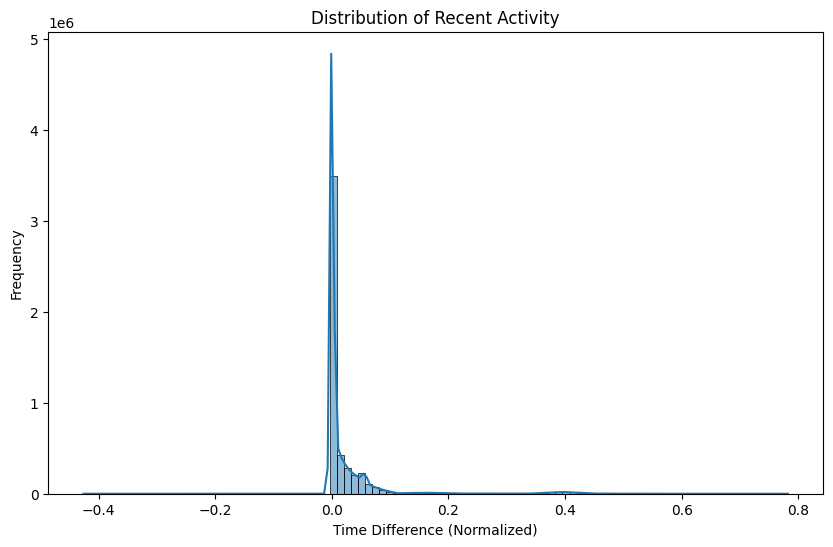

count    5.078336e+06
mean     2.232921e-02
std      6.453158e-02
min     -4.259958e-01
25%      0.000000e+00
50%      4.320842e-04
75%      1.736193e-02
max      7.819939e-01
Name: Recent Activity, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Recent Activity Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['Recent Activity'], bins=100, kde=True)
plt.title('Distribution of Recent Activity')
plt.xlabel('Time Difference (Normalized)')
plt.ylabel('Frequency')
plt.show()

# Temel İstatistikleri Kontrol Et
print(df['Recent Activity'].describe())

In [ ]:
df['Recent Activity'] = df['Recent Activity'].clip(lower=0)

In [ ]:
import numpy as np
df['Recent Activity Log'] = np.log1p(df['Recent Activity'])

In [ ]:
df['High_Frequency'] = (df['Recent Activity'] < 0.01).astype(int)

In [ ]:
print(df['Recent Activity'].describe())
print((df['Recent Activity'] < 0).sum())

count    5.078336e+06
mean     2.244114e-02
std      6.447466e-02
min      0.000000e+00
25%      0.000000e+00
50%      4.320842e-04
75%      1.736193e-02
max      7.819939e-01
Name: Recent Activity, dtype: float64
0


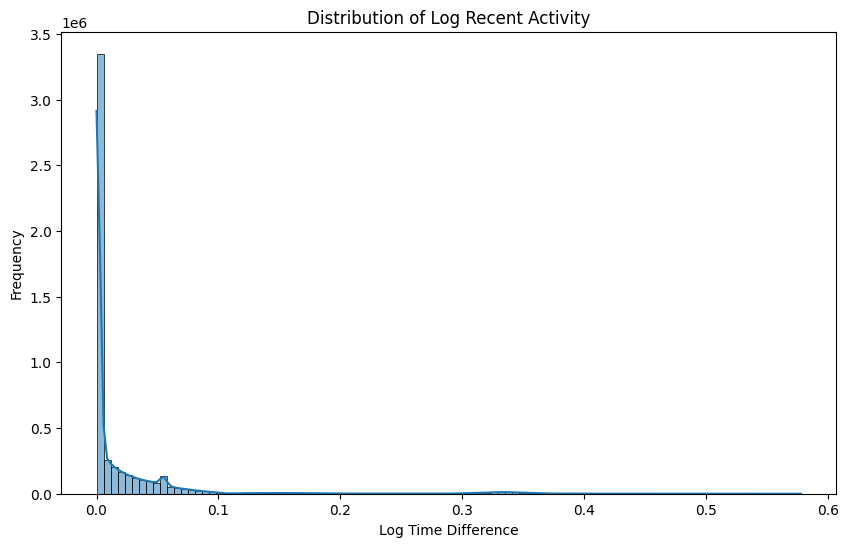

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(df['Recent Activity Log'], bins=100, kde=True)
plt.title('Distribution of Log Recent Activity')
plt.xlabel('Log Time Difference')
plt.ylabel('Frequency')
plt.show()

In [ ]:
print(df['Recent Activity'].quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

0.25    0.000000
0.50    0.000432
0.75    0.017362
0.90    0.056014
0.95    0.083510
0.99    0.400621
Name: Recent Activity, dtype: float64


In [ ]:
df['High_Frequency'] = (df['Recent Activity'] < 0.017).astype(int)

In [ ]:
print(df['High_Frequency'].value_counts())

High_Frequency
1    3797327
0    1281009
Name: count, dtype: int64


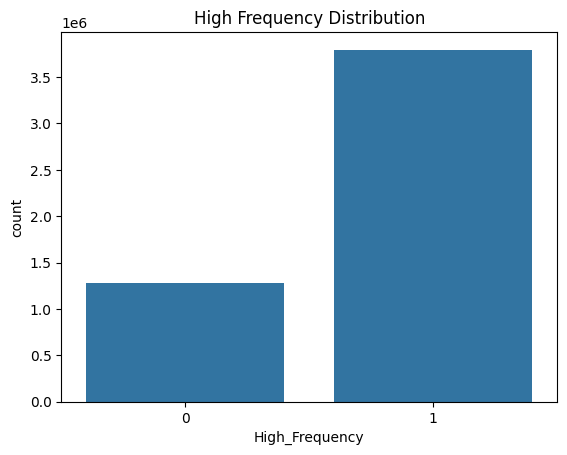

In [ ]:
import seaborn as sns
sns.countplot(x='High_Frequency', data=df)
plt.title('High Frequency Distribution')
plt.show()

In [ ]:
df['High_Frequency_New3'] = (df['Recent Activity'] < 0.4).astype(int)

In [ ]:
print(df['High_Frequency_New3'].value_counts())

High_Frequency_New3
1    5026694
0      51642
Name: count, dtype: int64
